In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.signal
import os
import pickle
from scipy.stats import spearmanr, gaussian_kde


In [2]:
df = pd.read_csv("../../backup/dbscan_clusterability.csv")

In [3]:
df = df.drop_duplicates(subset="category")

In [4]:
df["perc_big_clusters"] = df["n_big_clusters"] / df["tot_n_clusters"]

In [5]:
df["perc_small_clusters"] = 1-df["perc_big_clusters"]

In [6]:
df["n_big_clusters"].describe()

count    344.000000
mean       3.578488
std        2.317308
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       22.000000
Name: n_big_clusters, dtype: float64

## Focus on % noise

In [7]:
df.sort_values("perc_noise", ascending=True, inplace=True)

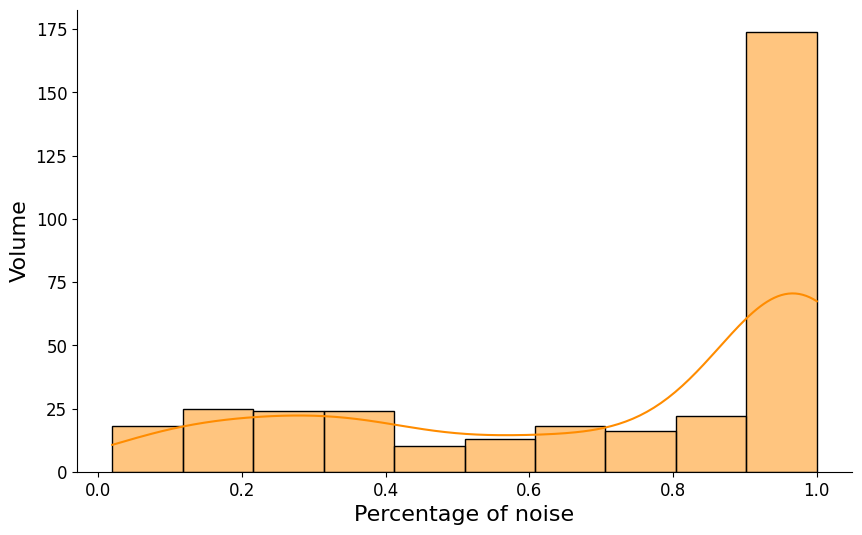

In [10]:
# get desnity distribution of perc_noise, with histogram and kernel density estimate
plt.figure(figsize=(10,6))
sns.histplot(df['perc_noise'], bins=10, kde=True, color='darkorange')
plt.xlabel('Percentage of noise', fontsize=16)
plt.ylabel('Volume', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()
# save as pdf
plt.savefig("../plots_downstream/perc_noise_distribution.pdf", bbox_inches='tight')

Find local minimum between the two modes

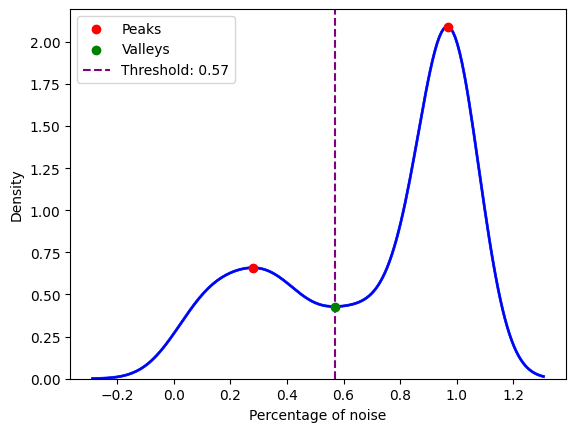

0.5698004492020455

In [11]:
perc_noise = df["perc_noise"]   

# KDE plot
sns.kdeplot(perc_noise, color="blue", linewidth=2)
plt.xlabel("Percentage of noise")
plt.ylabel("Density")

# Fit KDE using seaborn's default bandwidth
kde = sns.kdeplot(perc_noise).get_lines()[0].get_data()
x_vals, y_vals = kde[0], kde[1]

# Find local maxima and minima
peaks, _ = scipy.signal.find_peaks(y_vals)
valleys, _ = scipy.signal.find_peaks(-y_vals)  # Minima

# Identify the first valley after the first peak
if len(peaks) > 1 and len(valleys) > 0:
    first_valley = valleys[0]
    threshold = x_vals[first_valley]
else:
    threshold = None  # No clear separation

# Plot results
plt.plot(x_vals, y_vals, color="blue")
plt.scatter(x_vals[peaks], y_vals[peaks], color="red", label="Peaks", zorder=3)
plt.scatter(x_vals[valleys], y_vals[valleys], color="green", label="Valleys", zorder=3)
if threshold:
    plt.axvline(threshold, color="purple", linestyle="--", label=f"Threshold: {threshold:.2f}")
plt.legend()
plt.show()

# Output the computed threshold
threshold

### Focus on clusterable categories

In [12]:
categories_clusterable = df[perc_noise < threshold]

In [13]:
list_categories = categories_clusterable["category"].tolist()
# with open("../results/clusterability/categories_clusterable.pkl", "wb") as f:
#     pickle.dump(list_categories, f)

In [14]:
df_clusterable = categories_clusterable[["category"]]
df_clusterable.to_csv("../data/categories_clusterable.csv", index=False)


In [15]:
categories_nonclusterable = df[perc_noise >= threshold]

In [16]:
df_nonclusterable = categories_nonclusterable[["category"]]
df_nonclusterable.to_csv("../data/categories_nonclusterable.csv", index=False)


### Correlation with concreteness and sensorimotor

Add sensorimotor data for categories

In [18]:
sensorimotor = pd.read_csv("../data/sensorimotor_categories.csv")

Add concreteness scores

In [19]:
concreteness = pd.read_csv("../data/concreteness_categories.csv")

In [20]:
df_merge = df.merge(sensorimotor, on="category")
df_merge = df_merge.merge(concreteness, on="category")

In [21]:
# correlation matrix
var_corr = ['Auditory.mean', 'Gustatory.mean', 'Haptic.mean',
            'Interoceptive.mean', 'Olfactory.mean', 'Visual.mean', 'Foot_leg.mean',
            'Hand_arm.mean', 'Head.mean', 'Mouth.mean', 'Torso.mean', 'concreteness']
bonferroni = 0.05 / len(var_corr)
print(f"Bonferroni corrected p-value: {bonferroni}")

for var in var_corr:
        corr, pvalue = spearmanr(df_merge["perc_noise"], df_merge[var])

        if pvalue < bonferroni:
                print(f"{var}: {corr:.2f} ({pvalue:.2e}) *")
        else:
                print(var, corr, "Non significant")


Bonferroni corrected p-value: 0.004166666666666667
Auditory.mean 0.12365380803335806 Non significant
Gustatory.mean -0.04158169015276339 Non significant
Haptic.mean: -0.24 (6.55e-06) *
Interoceptive.mean -0.02409699954873006 Non significant
Olfactory.mean 0.06889710261654432 Non significant
Visual.mean -0.02185464908030915 Non significant
Foot_leg.mean -0.015450263739373468 Non significant
Hand_arm.mean: -0.19 (5.22e-04) *
Head.mean 0.05505463727600399 Non significant
Mouth.mean -0.012652582398274137 Non significant
Torso.mean 0.02081405169143809 Non significant
concreteness -0.05755283195116935 Non significant


In [22]:
df_merge["clusterability"] = 1-df_merge["perc_noise"]

0.2797202797202798 0.37856866966230307


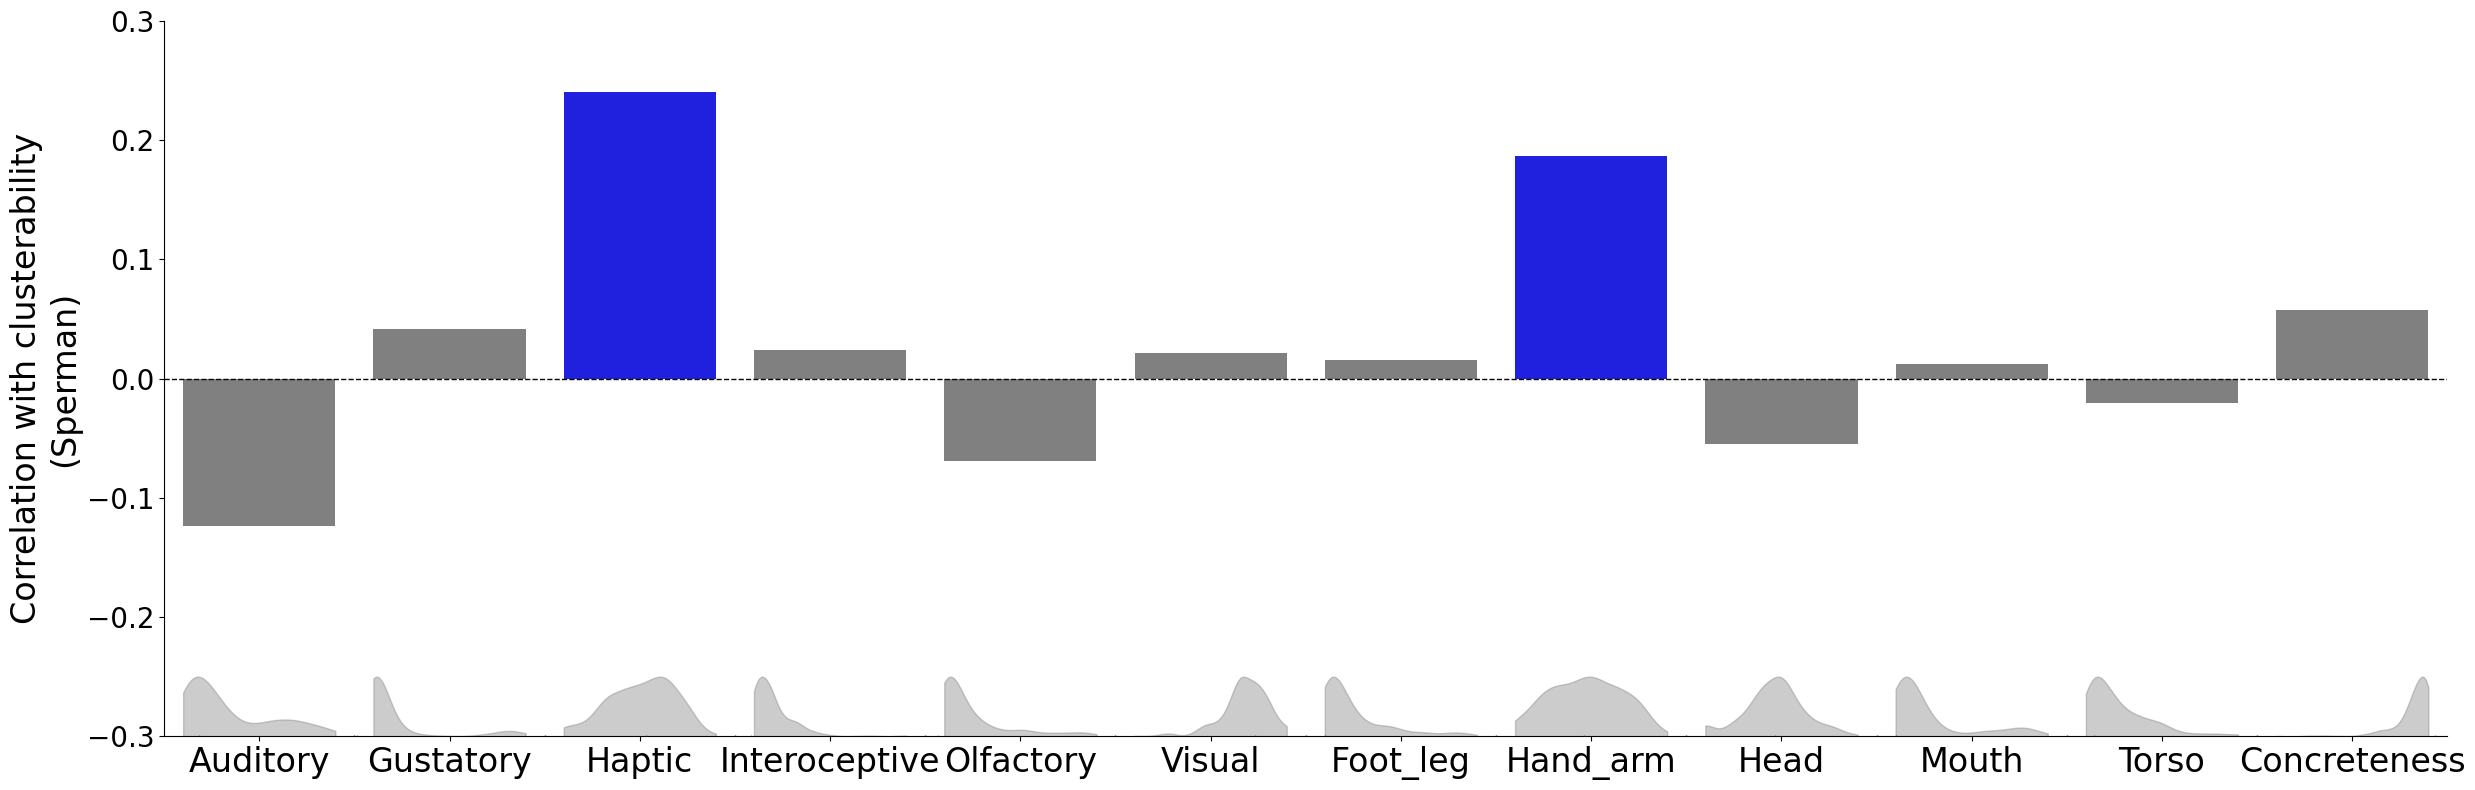

In [24]:
# --- compute correlations ---
correlations = []
mean_values = []
pvalues = []
for var in var_corr:
    corr, pvalue = spearmanr(df_merge["clusterability"], df_merge[var])
    correlations.append(corr)
    pvalues.append(pvalue)
    mean_val = np.mean(df_merge[var].dropna().values)
    mean_values.append(mean_val)

corr_meta, pvalue_meta = spearmanr(correlations, mean_values)
print(corr_meta, pvalue_meta) #non-significant

colors = ['red' if p < bonferroni and corr < 0 else 
          'blue' if p < bonferroni and corr > 0 else 
          'gray' for corr, p in zip(correlations, pvalues)]

# --- main bar plot ---
fig, ax = plt.subplots(figsize=(25,8))
sns.barplot(x=var_corr, y=correlations, palette=colors, width=0.8, ax=ax)

# horizontal line at 0
ax.axhline(0, color="black", linestyle="dashed", linewidth=1)

# --- add tiny horizontal KDE bumps centered at each tick ---
for i, var in enumerate(var_corr):
    values = df_merge[var].dropna().values
    if len(values) < 5:
        continue

    # KDE
    kde = gaussian_kde(values)
    xs = np.linspace(np.min(values), np.max(values), 200)
    ys = kde(xs)

    # normalize KDE height → max width of bump
    ys = ys / ys.max() * 0.05
    offset = -0.3

    # scale xs to the full width of the bar (width=0.8)
    bar_width = 0.8
    xs_scaled = (xs - xs.min()) / (xs.max() - xs.min()) * bar_width + (i - bar_width/2)

    # fill the bump
    ax.fill_between(xs_scaled, offset, ys + offset, alpha=0.4, color="gray")

    # add mini ticks for min, median, max values
    tick_positions = [np.min(values), np.median(values), np.max(values)]
    tick_positions_scaled = (np.array(tick_positions) - np.min(values)) / (np.max(values) - np.min(values)) - 0.5 + i
    for tp in tick_positions_scaled:
        ax.plot([tp, tp], [offset, offset - 0.02], color="black", lw=1)  # 0.02 = tick length

# --- formatting ---
labels = ['Auditory', 'Gustatory', 'Haptic', 'Interoceptive', 'Olfactory', 
          'Visual', 'Foot_leg', 'Hand_arm', 'Head', 'Mouth', 'Torso', 'Concreteness']
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, fontsize=24)
ax.set_ylabel("Correlation with clusterability\n(Sperman)", fontsize=24)
ax.set_ylim(-0.3, 0.3)
ax.tick_params(axis="y", labelsize=20)

ax.set_xlim(-0.5, len(var_corr)-0.5)
sns.despine()
plt.tight_layout()
plt.savefig("../plots_downstream/correlation_properties.pdf", bbox_inches='tight')
